In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import NMF
from surprise import Dataset
from surprise.model_selection import GridSearchCV

Ali Ghuman, Layth Yassin, Simon Yoon 

A recommendation was expertly curated for a suggestive dataset of 100k movie ratings. A technique known as grid search was employed with an extensive variety of hyperparameter values, specifically 486, to find the optimal values. The root mean squared that reigned supreme was 0.954 (compared to 0.963 baseline) with the following values for the hyperparameters: 
> 20 epochs
> 25 latent dimensions
> 0.06 regularization term for users
> 0.36 regularization term for items
> 0.02 regulatization term for user bias
> 0.005 regulatization term for item bias

In [5]:
n_epochs = [10, 20]
n_factors = [5, 25, 50]
reg_pu = [0.02, 0.06, 0.36]
reg_qi = [0.02, 0.06, 0.36]
reg_bu = [0.005, 0.02, 0.12]
reg_bi = [0.005, 0.02, 0.12]

gs = GridSearchCV(NMF, {"n_epochs": n_epochs, "n_factors": n_factors, 
                "reg_pu": reg_pu, "reg_qi": reg_qi,
                "reg_bu": reg_bu, "reg_bi": reg_bi}, measures=["rmse"])
gs.fit(Dataset.load_builtin('ml-100k'))
print(gs.best_score["rmse"], gs.best_params["rmse"])

0.9540216296692338 {'n_epochs': 20, 'n_factors': 25, 'reg_pu': 0.06, 'reg_qi': 0.36, 'reg_bu': 0.02, 'reg_bi': 0.005}


In [12]:
LAMBDA = 0.001
def procure_loss(P, U, df, hash_map_item, movie_map):
    loss = 0
    for i, row in df.iterrows():
        i = hash_map_item[int(row["userId"])]
        j = movie_map[int(row["movieId"])]
        loss += (row["rating"] - U[i, :] @ P[j, :]) ** 2 + LAMBDA * (np.linalg.norm(U[i, :]) + np.linalg.norm(P[j, :]) )
    return loss

def get_r(df: pd.DataFrame, num_item, hash_map_item, flag) -> np.ndarray:
    r = np.zeros((num_item, 1))
    for k, row in df.iterrows():
        i = int(row["userId"]) if flag else row["movieId"]
        i = hash_map_item[i]
        r[i] = row["rating"]
    return r

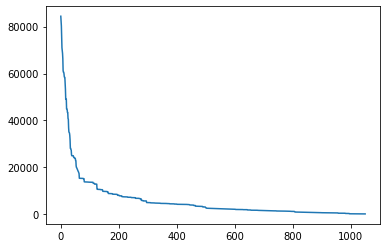

In [18]:
#Tuned Lambda parameter as well as latent_var to find values that optimize the loss curve. 
#latent_var of 10 was too small and had a terrible loss curve, raising it to 50 made a good convergence graph. 

df = pd.read_csv("ml-latest-small/ratings.csv").drop("timestamp", axis = 1)

df = df[df["userId"] < 200]
df = df[df["movieId"] < 100]

user_ids = np.sort(df["userId"].unique())
movie_ids = np.sort(df["movieId"].unique())

num_users = user_ids.shape[0]
num_movies = movie_ids.shape[0]

hash_map_movies = {}
for i in range(num_movies):
    if movie_ids[i] not in hash_map_movies:
        hash_map_movies[movie_ids[i]] = i

hash_map_users = {}
for i in range(num_users):
    if user_ids[i] not in hash_map_users:
        hash_map_users[user_ids[i]] = i

latent_var  = 50
user_matrix = np.random.uniform(0, 1, (num_users, latent_var))
movie_matrix = np.random.uniform(0, 1, (num_movies, latent_var))

loss = np.zeros(df.shape[0])
loss_counter = 0
for i, row in df.iterrows():
    user_ratings = df[df["userId"] == row["userId"]]
    r_user = get_r(user_ratings, num_movies, hash_map_movies, 0)
    user_matrix_row_updated = np.linalg.inv(movie_matrix.T @ movie_matrix + LAMBDA * np.identity(movie_matrix.shape[1])) @ movie_matrix.T @ r_user
    k = hash_map_users[int(row["userId"])]
    user_matrix[k, :] = user_matrix_row_updated.flatten()

    movie_ratings = df[df["movieId"] == row["movieId"]]
    r_movie = get_r(movie_ratings, num_users, hash_map_users, 1)
    movie_matrix_row_updated = np.linalg.inv(user_matrix.T @ user_matrix + LAMBDA * np.identity(user_matrix.shape[1])) @ user_matrix.T @ r_movie
    k = hash_map_movies[int(row["movieId"])]
    movie_matrix[k, :] = movie_matrix_row_updated.flatten()

    loss[loss_counter] = procure_loss(movie_matrix, user_matrix, df, hash_map_users, hash_map_movies)
    loss_counter += 1
plt.figure()
plt.plot(loss)
plt.show()